# Examples

In [1]:
#the new library
import protolib as pl

#General python stuff
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

path = pl.test_data_path()

## Open a file and read

f.total_frames=100
f.shape=[512, 1024]
f.bytes_per_frame=1048576
f.bits_per_pixel=16
Shape of data: (100, 512, 1024)


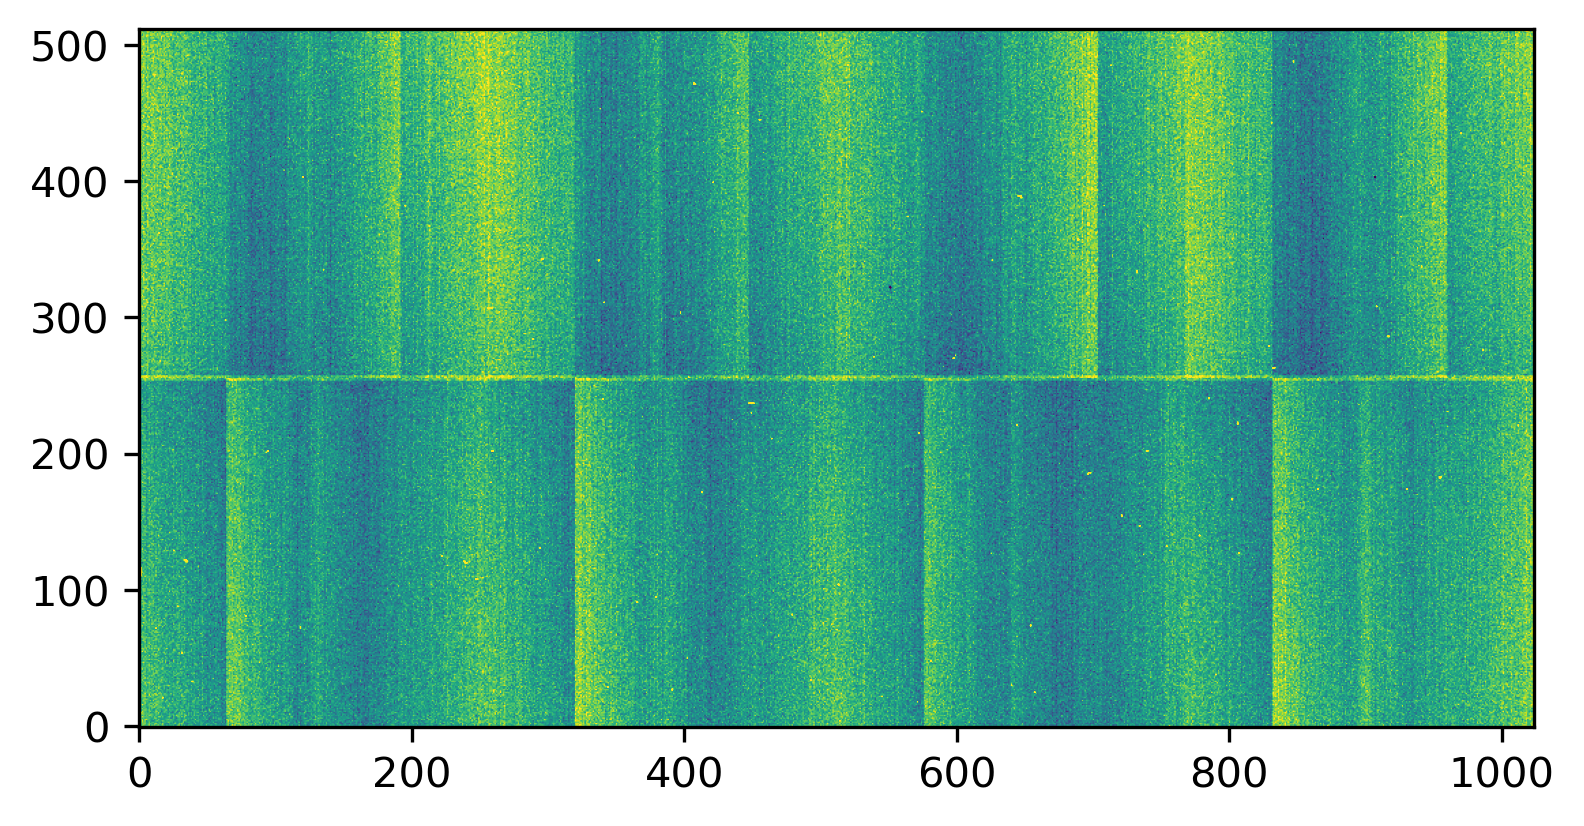

In [4]:
#open a file based on the master file name 
f = pl.File(path/'jungfrau/run_master_0.raw')

#query the file 
print(f"{f.total_frames=}")
print(f"{f.shape=}")
print(f"{f.bytes_per_frame=}")
print(f"{f.bits_per_pixel=}")

# #Read data
data = f.read()
print(f"Shape of data: {data.shape}")

# #plot the first image
fig, ax = plt.subplots()
im = ax.imshow(data[0], origin = 'lower')
im.set_clim(2000,3000)

## Loop over a file

(200.0, 700.0)

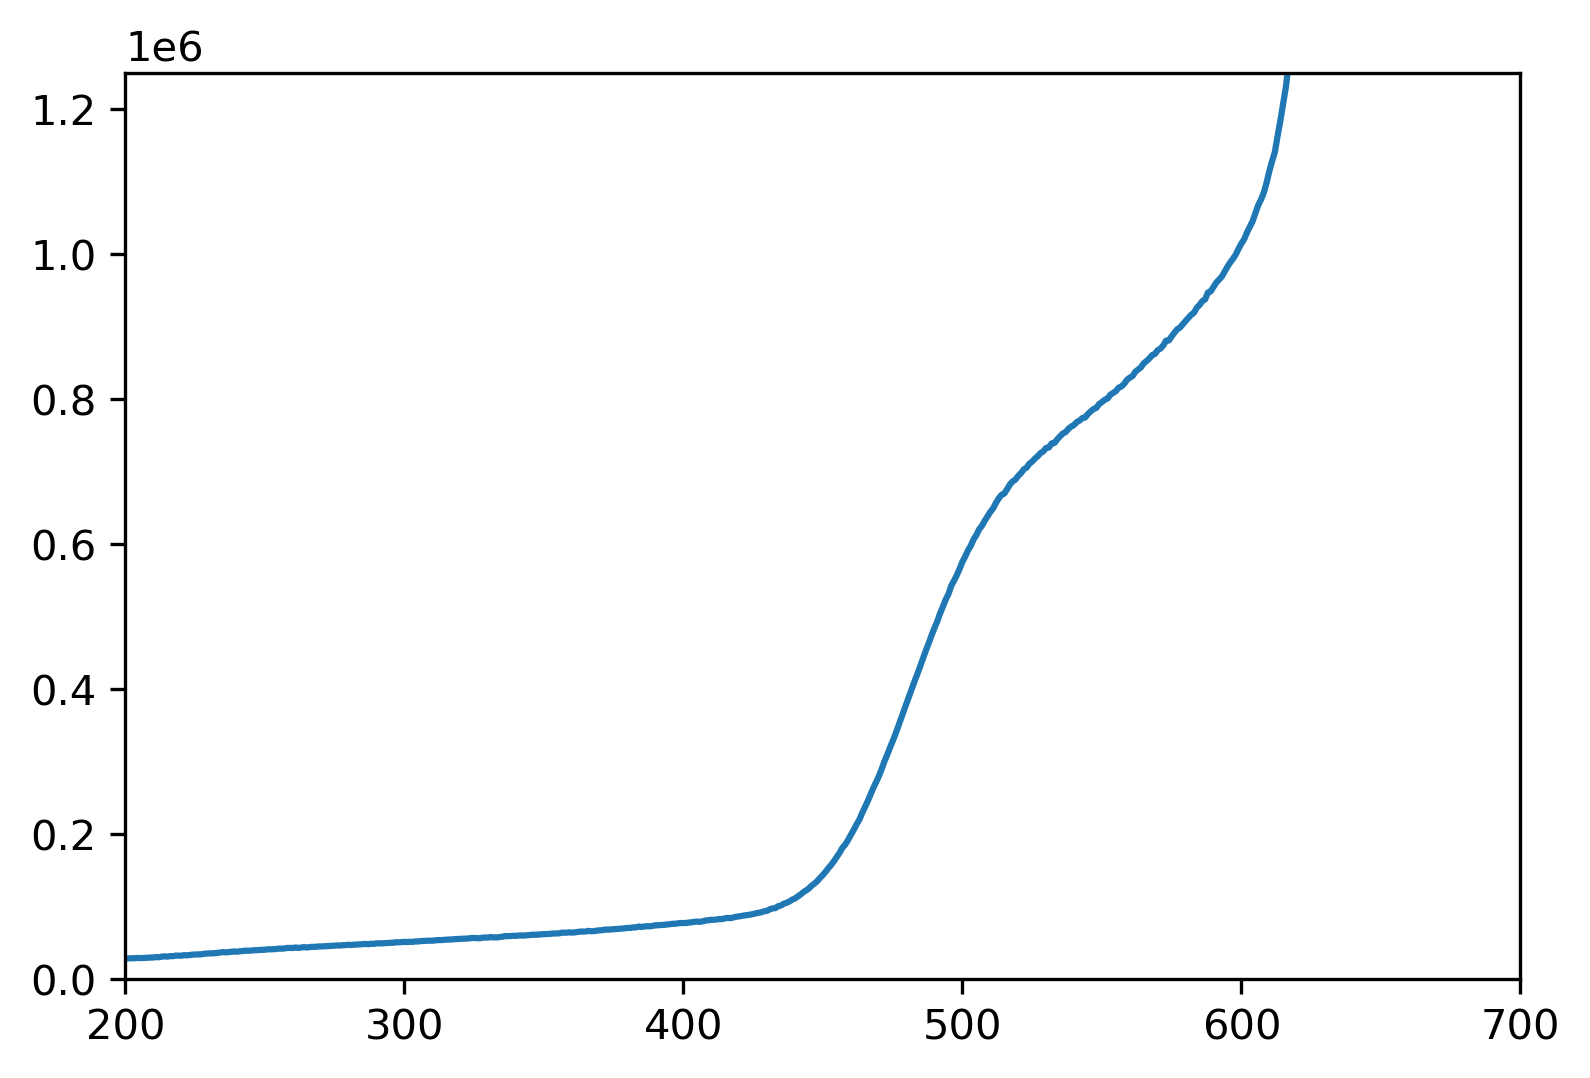

In [3]:
with pl.File(path/"mythen3/TiScan_master_0.raw") as file: 
    y = np.zeros(file.total_frames)
    for i, frame in enumerate(file):
        y[i] = frame[600:1000].sum()

fig, ax = plt.subplots()
ax.plot(y)
ax.set_ylim(0,1.25e6)
plt.xlim(200, 700)

In [2]:
files = (path/'mythen3').glob('*')
for file in files:
    if file.suffix == '.raw':
        print(file)

/home/l_frojdh/data/protolib_test/mythen3/TiScan_d1_f0_0.raw
/home/l_frojdh/data/protolib_test/mythen3/run_v7_d0_f0_0.raw
/home/l_frojdh/data/protolib_test/mythen3/run_v7_d0_f1_0.raw
/home/l_frojdh/data/protolib_test/mythen3/run_v7_d0_f2_0.raw
/home/l_frojdh/data/protolib_test/mythen3/TiScan_master_0.raw
/home/l_frojdh/data/protolib_test/mythen3/TiScan_d0_f0_0.raw
/home/l_frojdh/data/protolib_test/mythen3/run_v7_d0_f3_0.raw


## Loop over multiple files

In [ ]:
files = (path/'mythen3/series').glob('*')
files = [f for f in files if f.suffix == '.raw']
for f in files:
    print(f)

In [ ]:
f = pl.File(path/'mythen3/series/run_master_0.raw')
print(f'{f.total_frames=}')

In [ ]:
data = f.read()
print(f'{data.shape=}')

In [ ]:
f = pl.File(path/'mythen3/series/run_master_0.raw')
i = 0
for frame in f:
    i+=1
print(f'looped over {i} frames')

## Sum Jungfrau frames

In [ ]:
path = Path("/Users/erik/data/clara")
pd_fname = pl.find_folder(path, '024')/'run_master_0.raw'
print(f'First file for pedestal: {pd_fname}')
pedestal = pl.pd_from_file(pd_fname)
calibration = np.load('/Users/erik/software/clara/data/calibration.npy')

data_fname = pl.find_folder(path, '026')/'run_master_0.raw'
print(f'Loading: {data_fname}')




In [ ]:
t0 = time.perf_counter()
with pl.File(data_fname) as file:
    total = np.zeros(file.shape)
    t2 = np.zeros(file.shape)
    print(f"Summing {file.total_frames} frames")
    for i,frame in enumerate(file):
        total += pl.apply_calibration(frame, pedestal, calibration)
#         total+=t2
        if not i%250:
            print("=", end = '')
print(f"\nFinished in: {time.perf_counter()-t0:.3}s")            


In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(total, origin = 'lower')
im.set_clim(0,1e7)

In [ ]:
t0 = time.perf_counter()
total = pl.sum_raw_file(data_fname, pedestal, calibration, 10.)
print(f"\nFinished in: {time.perf_counter()-t0:.3}s")       

In [ ]:
t0 = time.perf_counter()
total = pl.sum_raw_file_parallel(data_fname, pedestal, calibration, 10.)
print(f"\nFinished in: {time.perf_counter()-t0:.3}s")      

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(total, origin = 'lower')
im.set_clim(0,1e7)

## Clustering

In [ ]:
path = Path("/Users/erik/data/clara")
pd_fname = pl.find_folder(path, '054')/'run_master_0.raw'
print(f'First file for pedestal: {pd_fname}')
pedestal = pl.pd_from_file(pd_fname)
calibration = np.load('/Users/erik/software/clara/data/calibration.npy')

data_fname = pl.find_folder(path, '061')/'run_master_0.raw'
print(f'Loading: {data_fname}')

In [ ]:
t0 = time.perf_counter()
with pl.File(data_fname) as file:
    total = np.zeros(file.shape())
    print(f"Processing {file.total_frames()} frames")
    cf = pl.ClusterFinder(file.shape(), 10)
    for i,frame in enumerate(file):
        data = pl.apply_calibration(frame, pedestal, calibration)
        cf.find_clusters(data)
        if not i%250:
            print("=", end = '')
print(f"\nFinished in: {time.perf_counter()-t0:.3}s")   


hits = cf.hits()


In [ ]:
import boost_histogram as bh
xmin = 0
xmax = 300

t0 = time.perf_counter()
hist = bh.Histogram(bh.axis.Regular(bins=100, start=xmin, stop=xmax))
hist.fill(hits['energy'])
fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].bar(hist.axes[0].centers, hist.view(), width=hist.axes[0].widths, label = 'Measured')

peak = hist.view().max()
with np.load('/Users/erik/software/clara/data/edep.npz') as f:
    x = f['x']
    y = f['y']
ax[0].step(x, y*(peak/y.max()), '-', color = 'red', lw = 2, label = 'GEANT4', where='pre')
ax[0].set_xlabel('Edep/e- [keV]')
ax[0].legend()
ax[0].set_xlim(xmin, xmax)

hist2 = bh.Histogram(bh.axis.Regular(bins=10, start=0.5, stop=10.5))
hist2.fill(hits['size'])
ax[1].bar(hist2.axes[0].centers, hist2.view(), width=hist2.axes[0].widths, label = 'Measured')
ax[1].set_xlabel("Cluster size")
ax[1].legend()
ax[1].set_xlim(0.5, 10.5)
print(f"fill and plot histograms: {time.perf_counter()-t0:.3}s")
fig.suptitle("4 MeV at 122 cm", size = 22)